# Retrieve NetCDF and model gridded climate time-series for a watershed

### Case study:  the Sauk-Suiattle Watershed
<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Re-establish the paths to the mapping file
    3. Compute daily, monthly, and annual temperature and precipitation statistics
    4. Visualize precipitation results relative to the forcing data
    5. Visualize the time-series trends
    6. Save results back into HydroShare

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  Prepare HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [21]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import seaborn as sns

# data migration library
from utilities import hydroshare
import ogh
import ogh_xarray_landlab as oxl

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [3]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [6]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

For visualization purposes, we will also remap the study site shapefile, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. Since the shapefile was previously migrated, we can select 'N' for no overwriting.

In the usecase1 notebook, the treatgeoself function identified the gridded cell centroid coordinates that overlap with our study site. These coordinates were documented within the mapping file, which will be remapped here. In the usecase2 notebook, the downloaded files were cataloged within the mapping file, so we will use the mappingfileSummary function to characterize the files available for Sauk-Suiattle for each gridded data product.

In [7]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']


"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


This resource already exists in your userspace.
c532e0578e974201a0bc40a37ef2d284/
|-- c532e0578e974201a0bc40a37ef2d284/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.cpg
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shp
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shx
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.dbf
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.prj

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


In [91]:
def treatgeoself(shapefile, NAmer, mappingfile=os.path.join(os.getcwd(), 'mappingfile.csv'), buffer_distance=0.06):
    """
    TreatGeoSelf to some [data] lovin'!
    
    shapefile: (dir) the path to an ESRI shapefile for the region of interest
    Namer: (dir) the path to the ESRI shapefile, which has each 1/16th-degree gridded cell centroid and DEM elevation
    mappingfile: (str) the name of the output file; default is 'mappingfile.csv'
    buffer_distance: (float64) the multiplier for increasing the geodetic boundary area; default is 0.06
    """
    # conform projections to longlat values in WGS84
    reprojShapefile(shapefile, newprojdictionary={'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}, outpath=None)
    
    # read shapefile into a multipolygon shape-object
    shape_mp = getFullShape(shapefile)
    
    # read in the North American continental DEM points for the station elevations
    NAmer_datapoints = readShapefileTable(NAmer).rename(columns={'Lat': 'LAT', 'Long': 'LONG_', 'Elev': 'ELEV'})
    
    # generate maptable
    maptable = filterPointsinShape(shape_mp, 
                                   points_lat=NAmer_datapoints.LAT, 
                                   points_lon=NAmer_datapoints.LONG_,
                                   points_elev=NAmer_datapoints.ELEV,
                                   buffer_distance=buffer_distance, buffer_resolution=16, 
                                   labels=['LAT', 'LONG_', 'ELEV'])
    maptable.reset_index(inplace=True)
    maptable = maptable.rename(columns={'index': 'FID'})
    print(maptable.shape)
    print(maptable.head())
    
    # print the mappingfile
    maptable.to_csv(mappingfile, sep=',', header=True, index=False)
    return(mappingfile)


def filterPointsinShape(shape, points_lat, points_lon, points_elev=None, buffer_distance=0.06, 
                        buffer_resolution=16, labels=['LAT', 'LONG_', 'ELEV']):
    """
    Filter for datafiles that can be used
    
    shape: (geometry) a geometric polygon or MultiPolygon
    points_lat: (series) a series of latitude points in WGS84 projection
    points_lon: (series) a series of longitude points in WGS84 projection
    points_elev: (series) a series of elevation points in meters; default is None
    buffer_distance: (float64) a numerical multiplier to increase the geodetic boundary area
    buffer_resolution: (float64) the increments between geodetic longlat degrees
    labels: (list) a list of preferred labels for latitude, longitude, and elevation
    """
    # add buffer region
    region = shape.buffer(buffer_distance, resolution=buffer_resolution)
    
    # construct bounds
    minx, miny, maxx, maxy = region.bounds
    
    # construct points_elev if null
    if isinstance(points_elev, type(None)):
        points_elev=np.repeat(np.nan, len(points_lon))
        
    # filter the points to the regional bounds
    point_filter = points_lat.map(lambda y:(y>=miny)and(y<=maxy)) & points_lon.map(lambda x:(x>=minx)and(x<=maxx))
    points_lon = points_lon.loc[point_filter]
    points_lat = points_lat.loc[point_filter]
    points_elev = points_elev.loc[point_filter]
    
    # Intersection each coordinate with the region
    limited_list = []    
    for lon, lat, elev in zip(points_lon, points_lat, points_elev):
        gpoint = point.Point(lon, lat)
        if gpoint.intersects(region):
            limited_list.append([lat, lon, elev])

    maptable = pd.DataFrame.from_records(limited_list, columns=labels)
    return(maptable)

In [84]:
shape_mp = getFullShape(sauk)

# add buffer region
region = shape_mp.buffer(0.06, resolution=16)

# read in the North American continental DEM points for the station elevations
NAmer_datapoints = readShapefileTable(NAmer).rename(columns={'Lat': 'LAT', 'Long': 'LONG_', 'Elev': 'ELEV'})

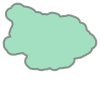

In [85]:
region

In [86]:
minx, miny, maxx, maxy = region.bounds

In [87]:
def reprojShapefile(sourcepath, outpath=None, 
                    newprojdictionary={'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}):
    """
    Convert a shapefile into a new projection
    
    sourcepath: (dir) the path to the .shp file
    newprojdictionary: (dict) the new projection definitions (default is longlat projection with WGS84 datum)
    outpath: (dir) the output path for the new shapefile
    """
    # if outpath is none, treat the reprojection as a file replacement
    if isinstance(outpath, type(None)):
        outpath = sourcepath
        
    shpfile = gpd.GeoDataFrame.from_file(sourcepath)
    shpfile = shpfile.to_crs(newprojdictionary)
    shpfile.to_file(outpath)
    
    
def getFullShape(shapefile):
    """
    Generate a MultiPolygon to represent each shape/polygon within the shapefile
    
    shapefile: (dir) a path to the ESRI .shp shapefile
    """
    shp = fiona.open(shapefile)
    mp = [shape(pol['geometry']) for pol in shp]
    mp = MultiPolygon(mp)
    shp.close()
    return(mp)


def readShapefileTable(shapefile):
    """
    Read in the datatable captured within the shapefile properties
    
    shapefile: (dir) a path to the ESRI .shp shapefile
    """
    shp = fiona.open(shapefile)
    centroid = [eachpol['properties'] for eachpol in shp]
    cent_df = pd.DataFrame.from_dict(centroid, orient='columns')
    shp.close()
    return(cent_df)

import geopandas as gpd
import fiona
from shapely.geometry import MultiPolygon, Polygon, box, point, shape
import dask as da
from dask.diagnostics import ProgressBar

In [92]:
%%time
mappingfile1=treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                          mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))
print(mappingfile1)

(99, 4)
   FID       LAT      LONG_    ELEV
0    0  48.53125 -121.59375  1113.0
1    1  48.46875 -121.46875   646.0
2    2  48.46875 -121.53125   321.0
3    3  48.46875 -121.59375   164.0
4    4  48.46875 -121.65625   369.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/Sauk_mappingfile.csv
CPU times: user 7.77 s, sys: 162 ms, total: 7.93 s
Wall time: 7.98 s


### Summarize the file availability from each watershed mapping file

In [37]:
%%time

# map the mappingfiles from usecase1
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                              mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))
print(mappingfile1)

(99, 4)
   FID       LAT      LONG_    ELEV
0    0  48.53125 -121.59375  1113.0
1    1  48.46875 -121.46875   646.0
2    2  48.46875 -121.53125   321.0
3    3  48.46875 -121.59375   164.0
4    4  48.46875 -121.65625   369.0
/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents/Sauk_mappingfile.csv
CPU times: user 19.5 s, sys: 440 ms, total: 19.9 s
Wall time: 20 s


In [38]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

Watershed,Sauk-Suiattle river
Median elevation in meters [range](Number of gridded cells),1171[164-2216] (n=99)


## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013 and Salathe 2014 mean temperature and mean total monthly precipitation in order to compare them with each other. The generated plots are automatically downloaded and saved as .png files within the "homedir" directory.

Let's compare the Livneh 2013 and Salathe 2014 using the period of overlapping history.

In [7]:
help(ogh.getDailyWRF_salathe2014)

Help on function getDailyWRF_salathe2014 in module ogh.ogh:

getDailyWRF_salathe2014(homedir, mappingfile, subdir='salathe2014/WWA_1950_2010/raw', catalog_label='dailywrf_salathe2014')
    Get the Salathe el al., 2014 raw Daily WRF files of interest using the reference mapping file
    
    homedir: (dir) the home directory to be used for establishing subdirectories
    mappingfile: (dir) the file path to the mappingfile, which contains LAT, LONG_, and ELEV coordinates of interest
    subdir: (dir) the subdirectory to be established under homedir
    catalog_label: (str) the preferred name for the series of catalogged filepaths



In [8]:
help(oxl.get_x_dailywrf_Salathe2014)

Help on function get_x_dailywrf_Salathe2014 in module ogh_xarray_landlab:

get_x_dailywrf_Salathe2014(homedir, spatialbounds, subdir='salathe2014/Daily_WRF_1970_1999/noBC', nworkers=4, start_date='1970-01-01', end_date='1989-12-31', rename_timelatlong_names={'LAT': 'LAT', 'LON': 'LON'}, file_prefix='sp_', replace_file=True)
    get Daily WRF data from Salathe et al. (2014) using xarray on netcdf files



## NetCDF retrieval and clipping to a spatial extent

The function get_x_dailywrf_salathe2014 retrieves and clips NetCDF files archived within the UW Rocinante NNRP repository. This archive contains daily data from January 1970 through December 1999 (30 years). Each netcdf file is comprised of meteorologic and VIC hydrologic outputs for a calendar month. The expected number of files would be 360 files (12 months for 30 years). 

In the code chunk below, 20 parallel workers will be initialized to distribute file retrieval and spatial clipping tasks. For each worker, they will wget the requested file, clip the netcdf file to gridded cell centroids within the the provided bounding box, then return the location of the spatially clipped output files.

In [9]:
maptable, nstations = ogh.mappingfileToDF(mappingfile1)
spatialbounds = {'minx':maptable.LONG_.min(), 'maxx':maptable.LONG_.max(),
                 'miny':maptable.LAT.min(), 'maxy':maptable.LAT.max()}

outputfiles = oxl.get_x_dailywrf_Salathe2014(homedir=homedir,
                                             subdir='salathe2014/Daily_WRF_1970_1999/noBC_netcdf',
                                             spatialbounds=spatialbounds,
                                             nworkers=20,
                                             start_date='1970-01-01', end_date='1999-12-31')

Number of gridded data files:99
Minimum elevation: 164.0m
Mean elevation: 1151.040404040404m
Maximum elevation: 2216.0m
[########################################] | 100% Completed | 14min  6.7s
CPU times: user 10min 54s, sys: 3min 39s, total: 14min 34s
Wall time: 14min 7s


In [ ]:
%%time
outfiledict = oxl.netcdf_to_ascii(homedir=homedir, 
                                  subdir='salathe2014/Daily_WRF_1970_1999/noBC_ascii', 
                                  mappingfile=mappingfile1,
                                  netcdfs=outputfiles,
                                  catalog_label='sp_WRF_NNRP_noBC')

In [ ]:
list(outfiledict.keys())

In [ ]:
ds_vars = [ds_var for ds_var in dict(ds_mf.variables).keys() 
           if ds_var not in ['YEAR','MONTH','DAY','TIME','LAT','LON']]




In [ ]:
help(ogh.mappingfileSummary)

In [ ]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

In [ ]:
%%time

ogh.getDailyMET_livneh2013(homedir, mappingfile1)
ogh.getDailyWRF_salathe2014(homedir, mappingfile1)

In [ ]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

### Create a dictionary of climate variables for the long-term mean (ltm).
#### INPUT: gridded meteorology ASCII files located from the Sauk-Suiattle Mapping file. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>OUTPUT: dictionary of dataframes where rows are temporal summaries and columns are spatial summaries

In [ ]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

In [ ]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['PRECIP'],
                        dataset='dailymet_livneh2013',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1])

### Compute the total monthly and yearly precipitation, as well as the mean values across time and across stations
#### INPUT: daily precipitation for each station from the long-term mean dictionary (ltm) <br/>OUTPUT: Append the computed dataframes and values into the ltm dictionary

In [ ]:
# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailymet_livneh2013',
                                   start_date=dr[0],
                                   end_date=dr[1])

## Repeat spatial-temporal computations with Salathe et al 2014 WRF data

In [ ]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        variable_list=['PRECIP'],
                        dataset='dailywrf_salathe2014',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1],
                        df_dict=ltm)

# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='PRECIP_dailywrf_salathe2014',
                                   start_date=dr[0],
                                   end_date=dr[1])

In [ ]:
# print the name of the Livneh et al. 2013 raw MET and Salathe et al. 2014 raw WRF dataframes and values within ltm
sorted(ltm.keys())

In [ ]:
# initialize list of outputs
files=[]

# create the destination path for the dictionary of dataframes
ltm_sauk=os.path.join(homedir, 'ltm_sauk.json')
ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=ltm_sauk)
files.append(ltm_sauk)

# append the mapping file for Sauk-Suiattle gridded cell centroids
files.append(mappingfile1)

### Visualize the "average monthly total precipitations"

#### INPUT: dataframe with each month as a row and each station as a column. <br/>OUTPUT: A png file that represents the distribution across stations (in Wateryear order)

In [ ]:
# # two lowest elevation locations
lowE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=164)

# one highest elevation location
highE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=2216)

# combine references together
reference_lines = highE_ref + lowE_ref
reference_lines


In [ ]:
# consider value range when comparing Livneh to Salathe 
vr = ogh.valueRange([ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'], 
                     ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014']])

print(vr.min(), vr.max())

In [ ]:
temp, nstation = ogh.mappingfileToDF(mappingfile1)
temp.head(10)

In [ ]:
# """
# #Higher resolution children gridded cells 
# #get data from Lower resolution parent grid cells to the children
# """
# import landlab as L2

# watershed_dem_sc = os.path.join(homedir, 'DEM_10m.asc')
# (rmg_sc, z_sc) = L2.io.read_esri_ascii(watershed_dem_sc, name='topographic__elevation')
# rmg_sc.set_watershed_boundary_condition(z_sc)

In [ ]:
# test0=pd.read_table(watershed_dem_sc, nrows=5, sep='\s+', header=None).set_index(0)[1].to_dict()
# print(test0)

# test1 = pd.read_table(watershed_dem_sc, 
#                       skiprows=6, 
#                       nrows=test0['nrows'],
#                       sep='\s+',
#                       header=None)
# print(test1.tail())

In [ ]:
# test1.unstack().as_matrix().shape

In [ ]:
# test1.as_matrix().shape

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box, Polygon
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

In [ ]:
def calculateUTMbounds(mappingfile, mappingfile_crs={'init':'epsg:4326'}, spatial_resolution=0.06250):
    # read in the mappingfile
    map_df, nstation = ogh.mappingfileToDF(mappingfile)

    # loop though each LAT/LONG_ +/-0.06250 centroid into gridded cells
    geom=[]
    midpt = spatial_resolution
    for ind in map_df.index:
        mid = map_df.loc[ind]
        geom.append(box(mid.LONG_- midpt, mid.LAT - midpt, mid.LONG_ + midpt, mid.LAT + midpt, ccw=True))

    # generate the GeoDataFrame
    test = gpd.GeoDataFrame(map_df, crs=mappingfile_crs, geometry=geom)

    # compile gridded cells to extract bounding box
    test['shapeName'] = 1

    # dissolve shape into new shapefile
    newShape = test.dissolve(by='shapeName').reset_index()
    newShape.bounds

    # take the minx and miny, and centroid_x and centroid_y
    minx, miny, maxx, maxy = newShape.bounds.loc[0]
    lon0, lat0 = np.array(newShape.centroid[0])

    # generate the basemap raster
    fig = plt.figure(figsize=(10,10), dpi=500)
    ax1 = plt.subplot2grid((1,1),(0,0))
    m = Basemap(projection='tmerc', resolution='h', ax=ax1, lat_0=lat0, lon_0=lon0,
                llcrnrlon=minx, llcrnrlat=miny, urcrnrlon=maxx, urcrnrlat=maxy)

    # transform each polygon to the utm basemap projection
    for ind in newShape.index:
        eachpol = newShape.loc[ind]
        newShape.loc[ind,'g2'] = shapely.ops.transform(m, eachpol['geometry'])
    
    # remove the plot
    plt.gcf().clear()

    # establish the UTM basemap bounding box dimensions
    minx2, miny2, maxx2, maxy2 = newShape['g2'].iloc[0].bounds
    return(minx2, miny2, maxx2, maxy2)


In [ ]:
minx2, miny2, maxx2, maxy2 = calculateUTMbounds(mappingfile=mappingfile1,
                                                mappingfile_crs={'init':'epsg:4326'},
                                                spatial_resolution=0.06250)

minx2, miny2, maxx2, maxy2

In [ ]:
# # def mappingfileToUTM (mappingfile, spatial_resolution, starting_shape_projection={'init':'epsg:4326'}):

# # read in the mappingfile
# #map_df, nstation = ogh.mappingfileToDF(mappingfile)
# map_df, nstation = ogh.mappingfileToDF(mappingfile1)

# # turn mapping file coordinates into LatLong gridded cells
# #midpt = spatial_resolution
# midpt = 0.06250
# geom=[]
# for ind in map_df.index:
#     mid = map_df.loc[ind]
#     geom.append(box(mid.LONG_- midpt, mid.LAT - midpt, mid.LONG_ + midpt, mid.LAT + midpt, ccw=True))

# # assemble geodataframe for each cell
# test = gpd.GeoDataFrame(map_df, crs={'init':'epsg:4326'}, geometry=geom)

# # dissolve into a single shape polygon
# test['shapeName'] = 1
# newShape = test.dissolve(by='shapeName').reset_index()
# del test['shapeName']

# # take the bounding box and centroids coordinates
# minx, miny, maxx, maxy = newShape.bounds.iloc[0]
# lon0, lat0 = np.array(newShape.centroid[0])
# print(minx, miny, maxx, maxy)

# # generate the basemap raster
# fig = plt.figure(figsize=(10,10), dpi=500)
# ax1 = plt.subplot2grid((1,1),(0,0))
# m = Basemap(projection='tmerc', resolution='h', ax=ax1, lat_0=lat0, lon_0=lon0,
#             llcrnrlon=minx, llcrnrlat=miny, urcrnrlon=maxx, urcrnrlat=maxy)
    
# # transform each polygon to the utm basemap projection
# for ind in newShape.index:
#     eachpol = newShape.loc[ind]
#     newShape.loc[ind,'geometry'] = shapely.ops.transform(m, eachpol['geometry'])

# # print the bounds by the new UTM projection
# minx, miny, maxx, maxy = newShape.bounds.iloc[0]
# print(minx, miny, maxx, maxy)

# # transform each polygon to the utm basemap projection
# for ind in test.index:
#     eachpol = test.loc[ind]
#     test.loc[ind,'geometry'] = shapely.ops.transform(m, eachpol['geometry'])

In [ ]:
tmp = gpd.GeoDataFrame(test, crs={'init':m.projection}, geometry=test['geometry'])
tmp

In [ ]:
test3 = tmp.plot(column='ELEV', figsize=(10,10))

In [ ]:
minx2, miny2, maxx2, maxy2

In [ ]:
(maxx-minx)/100

In [ ]:
raster = r.RasterModelGrid((len(row_list), len(col_list)), spacing=(dy, dx))

In [ ]:
import landlab.grid.raster as r

def rasterDimensions (maxx, maxy, minx=0, miny=0, dy=100, dx=100):
    # construct the range
    x = pd.Series(range(int(minx),int(maxx)+1,1))
    y = pd.Series(range(int(miny),int(maxy)+1,1))
    
    # filter for values that meet the increment or is the last value
    cols = pd.Series(x.index).apply(lambda x1: x[x1] if x1 % dx == 0 or x1==x[0] or x1==x.index[-1] else None)
    rows = pd.Series(y.index).apply(lambda y1: y[y1] if y1 % dy == 0 or y1==y[0] or y1==y.index[-1] else None)
    
    # construct the indices
    row_list = np.array(rows.loc[pd.notnull(rows)])
    col_list = np.array(cols.loc[pd.notnull(cols)])
    
    # construct the raster
    raster = r.RasterModelGrid((len(row_list), len(col_list)), spacing=(dy, dx))
    raster.add_zeros
    return(raster, row_list, col_list)

In [ ]:
# generate a raster
raster, t1, t2 = rasterDimensions (minx=minx2, miny=miny2, maxx=maxx2, maxy=maxy2, dx=100, dy=100)

In [ ]:
raster.shape

In [ ]:
t1, t2

In [ ]:
raster.boundary_nodes

In [ ]:
def mappingfileToRaster(mappingfile, spatial_resolution=0.01250, approx_distance_m_x=6000):
    # assess raster dimensions from mappingfile
    mf, nstations = mappingfileToDF(mappingfile, colvar=None)
    ncol = int((mf.LONG_.max()-mf.LONG_.min())/spatial_resolution +1)
    nrow = int((mf.LAT.max()-mf.LAT.min())/spatial_resolution +1)
    
    # dimensions of the raster
    row_list = [mf.LAT.min() + spatial_resolution*(station) for station in range(0,nrow,1)]    
    col_list = [mf.LONG_.min() + spatial_resolution*(station) for station in range(0,ncol,1)]
    
    # initialize RasterModelGrid
    raster = r.RasterModelGrid(nrow, ncol, dx=approx_distance_m_x)
    raster.add_zeros

    # initialize node list
    df_list=[]

    # loop through the raster nodes (bottom to top arrays)
    for row_index, nodelist in enumerate(raster.nodes):
        
        # index bottom to top arrays with ordered Latitude
        lat = row_list[row_index]
        
        # index left to right with ordered Longitude
        for nodeid, long_ in zip(nodelist, col_list):
            df_list.append([nodeid, lat, long_])

    # convert to dataframe
    df = pd.DataFrame.from_records(df_list).rename(columns={0:'nodeid',1:'LAT',2:'LONG_'})
    
    # identify raster nodeid and equivalent mappingfile FID
    df = df.merge(mf[['FID','LAT','LONG_','ELEV']], how='outer', on=['LAT','LONG_'])
    return(df, raster)

In [ ]:
nodeXmap, raster = ogh.mappingfileToRaster(mappingfile=mappingfile1,
                                           spatial_resolution=0.06250,
                                           approx_distance_m_x=6000)

In [ ]:
raster.shape

In [ ]:
vector = ogh.rasterVector(vardf=ltm['meanbymonthsum_PRECIP_dailymet_livneh2013'],
                          vardf_dateindex=3,
                          crossmap=nodeXmap,
                          nodata=-9999)
np.array(vector)

In [ ]:
vector = ogh.rasterVector(vardf=ltm['meanbymonthsum_PRECIP_dailywrf_salathe2014'],
                          vardf_dateindex=3,
                          crossmap=nodeXmap,
                          nodata=-9999)
vector

### Visualize the "average monthly total precipitation"

## 5. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

### Total files and image to migrate

In [ ]:
len(files)

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Computed spatial-temporal summaries of two gridded data product data sets for Sauk-Suiattle'
abstract = 'This resource contains the computed summaries for the Meteorology data from Livneh et al. 2013 and the WRF data from Salathe et al. 2014.'
keywords = ['Sauk-Suiattle', 'Livneh 2013', 'Salathe 2014','climate','hydromet','watershed', 'visualizations and summaries'] 
rtype = 'genericresource'

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

In [ ]:
df=df_bc45
models=[model for model in df.columns if model not in ['Date','Year','Month','Day']]
time=time1



In [ ]:
import pandas as pd

t=pd.DataFrame({'test':['terrific']})

In [ ]:
t1=pd.DataFrame({'test':['terrific']})
t2=pd.DataFrame({'test':['terrific']})
t3=pd.DataFrame({'test':['terrific']})
t4=pd.DataFrame({'test':['terrific']})

for somedf in (t1, t2, t3, t4):
    if somedf in locals():
        print(locals())
    list(somedf.to_dict().keys())

In [ ]:
for each in [t1,t2,t2,t4]:
    if each in globals().keys():
        print(each)

In [ ]:
y = eval(t)
str(y)